<a href="https://colab.research.google.com/github/Sahil-Singh2002/Solving-PDE-s-using-Deep-Learning-Algorithms/blob/main/2Dinitial_parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np

################################################################################
# 1. Domain Checks:  Now everything is in the form  a^T x >= b.
################################################################################

def domain_1(x: np.ndarray) -> bool:
    """
    Check if a point x is in the triangle defined by:
       1) [1,0]^T x >= 0       (i.e. x >= 0)
       2) [0,1]^T x >= 0       (i.e. y >= 0)
       3) [-1,-1]^T x >= -1    (i.e. x + y <= 1)
    """
    # boundary_1 = a=[1,0], b=0
    # boundary_2 = a=[0,1], b=0
    # boundary_3 = a=[-1,-1], b=-1
    checks = []
    checks.append(np.dot(np.array([1,0]), x) >= 0.0)    # x >= 0
    checks.append(np.dot(np.array([0,1]), x) >= 0.0)    # y >= 0
    checks.append(np.dot(np.array([-1,-1]), x) >= -1.0) # x+y <= 1 => -(x+y)>=-1
    return all(checks)

def domain_2(x: np.ndarray, w_i: np.ndarray, b_i: float) -> bool:
    """
    Check if x is in domain_1 AND also satisfies  w_i^T x >= b_i.
    (Here, w_i^T x >= b_i is also in 'Option A' form.)
    """
    return domain_1(x) and (np.dot(w_i, x) >= b_i)

def domain_3(x: np.ndarray, w_i: np.ndarray, b_i: float, w_j: np.ndarray, b_j: float) -> bool:
    """Check if x is in domain_2 AND satisfies w_j^T x + b_j >= 0."""
    return domain_2(x, w_i, b_i) and (np.dot(w_j, x) >= b_j)

################################################################################
# 2. Utility functions: distance, reorder, duplicates, etc.
################################################################################

def euclidean_distance(coord1: np.ndarray, coord2: np.ndarray) -> float:
    """Compute Euclidean distance between two points."""
    return np.linalg.norm(coord1 - coord2)

def reorder_nodes(reference_node: np.ndarray, nodes_to_sort: list[dict]) -> list[dict]:
    """
    Reorders nodes based on proximity to a reference point.
    The closest node is chosen next, and so on.
    """
    ordered_nodes = []
    remaining_nodes = nodes_to_sort.copy()
    current_reference = reference_node

    while remaining_nodes:
        closest_node = min(
            remaining_nodes,
            key=lambda node: euclidean_distance(current_reference, node["coordinates"])
        )
        ordered_nodes.append(closest_node)
        remaining_nodes.remove(closest_node)
        current_reference = closest_node["coordinates"]

    return ordered_nodes

def remove_duplicate_coordinates(nodes):
    """Removes nodes with identical coordinates (within a tolerance)."""
    unique_nodes = []
    seen_coords = set()

    for node in nodes:
        coords_rounded = tuple(np.round(node["coordinates"], 8))
        if coords_rounded not in seen_coords:
            seen_coords.add(coords_rounded)
            unique_nodes.append(node)
    return unique_nodes

################################################################################
# 3. Step 1: Solve boundary pair intersections.
#    Now each boundary is  a^T x = b  in ">= b" sense.
################################################################################

def step_1(boundary_1, boundary_2, boundary_3, b1, b2, b3):
    """
    Solve the linear systems for the three pairs of boundaries:
      1) boundary_1 & boundary_2
      2) boundary_1 & boundary_3
      3) boundary_2 & boundary_3

    This yields the triangle's vertices in 'Option A' style.
    """
    # Solve  a^T x = b  with two lines
    A12 = np.array([boundary_1, boundary_2])  # e.g. x=0 & y=0 in the old sense
    b12 = np.array([b1, b2], dtype=float)
    x12 = np.linalg.solve(A12, b12)

    A13 = np.array([boundary_1, boundary_3])
    b13 = np.array([b1, b3], dtype=float)
    x13 = np.linalg.solve(A13, b13)

    A23 = np.array([boundary_2, boundary_3])
    b23 = np.array([b2, b3], dtype=float)
    x23 = np.linalg.solve(A23, b23)

    nodes_1 = [
        {"node": 1, "coordinates": x12, "A": A12, "b": b12},
        {"node": 2, "coordinates": x13, "A": A13, "b": b13},
        {"node": 3, "coordinates": x23, "A": A23, "b": b23},
    ]

    # Debug
    print("===== step_1: original 3 boundary intersections =====")
    for node in nodes_1:
        print(f"Node {node['node']} => coords={node['coordinates']}")
    print()
    return nodes_1

################################################################################
# 4. Step 2: Filter those nodes by domain_2 and add intersections with hyperplane
################################################################################

def step_2(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_i, b_i):
    """
    1) Collect triangle nodes from step_1.
    2) Keep only those in domain_2 ( i.e. a^T x >= b for the triangle,
       plus w_i^T x >= b_i ).
    3) Find intersection of hyperplane w_i^T x = b_i with each boundary line,
       then also filter them by domain_2.
    4) Merge, reorder, remove duplicates => final polygon node list.
    """
    # Step 1
    nodes_1 = step_1(boundary_1, boundary_2, boundary_3, b1, b2, b3)

    # Filter by domain_2
    print("===== step_2: filtering step_1 nodes with domain_2 =====")
    nodes_1_filtered = []
    for node in nodes_1:
        x_coord = node["coordinates"]
        in_dom = domain_2(x_coord, w_i, b_i)
        print(f"Node {node['node']} coords={x_coord}, domain_2={in_dom}")
        if in_dom:
            nodes_1_filtered.append(node)
    print()

    # Now find new intersections: w_i^T x = b_i with each boundary
    # Solve [w_i, boundary_k] x = [b_i, b_k]
    A4 = np.array([w_i, boundary_3])
    b4 = np.array([b_i, b3], dtype=float)
    x4 = np.linalg.solve(A4, b4)

    A5 = np.array([w_i, boundary_1])
    b5 = np.array([b_i, b1], dtype=float)
    x5 = np.linalg.solve(A5, b5)

    A6 = np.array([w_i, boundary_2])
    b6 = np.array([b_i, b2], dtype=float)
    x6 = np.linalg.solve(A6, b6)

    nodes_2_dummy = [
        {"node": 4, "coordinates": x4, "A": A4, "b": b4},
        {"node": 5, "coordinates": x5, "A": A5, "b": b5},
        {"node": 6, "coordinates": x6, "A": A6, "b": b6},
    ]

    print("===== step_2: intersection with hyperplane (before filtering) =====")
    for node in nodes_2_dummy:
        x_coord = node["coordinates"]
        in_dom = domain_2(x_coord, w_i, b_i)
        print(f"Node {node['node']} coords={x_coord}, domain_2={in_dom}")
    print()

    # Filter these intersections by domain_2
    nodes_2 = [n for n in nodes_2_dummy if domain_2(n["coordinates"], w_i, b_i)]

    # Reorder them if we have at least 1 node in nodes_1_filtered
    if nodes_1_filtered:
        last_ref = nodes_1_filtered[-1]["coordinates"]
        reordered_nodes_2 = reorder_nodes(last_ref, nodes_2)
    else:
        reordered_nodes_2 = nodes_2

    merged = nodes_1_filtered + reordered_nodes_2
    unique_nodes = remove_duplicate_coordinates(merged)

    print("===== step_2: final unique nodes (after merging & reorder) =====")
    for node in unique_nodes:
        print(f"Node {node['node']} => coords={node['coordinates']}")
    print()

    return unique_nodes

def step_3(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_i, b_i, w_j, b_j):
    """Extends step_2 by further filtering with a second hyperplane w_j^T x + b_j >= 0."""
    nodes_2 = step_2(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_i, b_i)

    print("===== Step 3: Checking step_2 nodes against domain_3 =====")
    nodes_2_filtered = []
    for node in nodes_2:
        x_coord = node["coordinates"]
        in_dom = domain_3(x_coord, w_i, b_i, w_j, b_j)
        print(f"Node {node['node']} => coords={x_coord}, domain_3={in_dom}")
        if in_dom:
            nodes_2_filtered.append(node)
    print()

    # Find new intersection for w_j^T x = b_j with boundary and previous hyperpplane
    A7 = np.array([w_j, boundary_3])
    b7 = np.array([b_j, b3], dtype=float)
    x7 = np.linalg.solve(A7, b7)

    A8 = np.array([w_j, boundary_1])
    b8 = np.array([b_j, b1], dtype=float)
    x8 = np.linalg.solve(A8, b8)

    A9 = np.array([w_j, boundary_2])
    b9 = np.array([b_j, b2], dtype=float)
    x9 = np.linalg.solve(A9, b9)

    A10 = np.array([w_j, w_i])
    b10 = np.array([b_j, b_i], dtype=float)
    x10 = np.linalg.solve(A10, b10)

    nodes_3_dummy = [
        {"node": 7, "coordinates": x7, "A": A7, "b": b7},
        {"node": 8, "coordinates": x8, "A": A8, "b": b8},
        {"node": 9, "coordinates": x9, "A": A9, "b": b9},
        {"node": 10, "coordinates": x10, "A": A10, "b": b10},
    ]
    print("===== step_3: intersection with hyperplane (before filtering) =====")
    for node in nodes_3_dummy:
        x_coord = node["coordinates"]
        in_dom = domain_3(x_coord, w_i, b_i, w_j, b_j)
        print(f"Node {node['node']} => coords={x_coord}, domain_3={in_dom}")
    print()

    # Filter these intersections by domain_3
    nodes_3 = [n for n in nodes_3_dummy if domain_3(n["coordinates"], w_i, b_i, w_j, b_j)]

    # Reorder them if we have at least 1 node in nodes_1_filtered
    if nodes_2_filtered:
        last_ref = nodes_2_filtered[-1]["coordinates"]
        reordered_nodes_3 = reorder_nodes(last_ref, nodes_3)
    else:
        reordered_nodes_3 = nodes_3

    merged = nodes_2_filtered + reordered_nodes_3
    unique_nodes = remove_duplicate_coordinates(merged)

    print("===== step_3: final unique nodes (after merging & reorder) =====")
    for node in unique_nodes:
        print(f"Node {node['node']} => coords={node['coordinates']}")
    print()

    return unique_nodes



################################################################################
# 5. The Partial-Sum "Area" Calculation (diagonalMatrix)
################################################################################

def euclidean_distance(coord1: np.ndarray, coord2: np.ndarray) -> float:
    """Compute Euclidean distance between two points."""
    return np.linalg.norm(coord1 - coord2)

def diagonalMatrix(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_i, b_i) -> float:
    """
    1) Get the polygon from step_2 (the intersection of the triangle and w_i^T x >= b_i).
    2) Use the partial-sum formula:  0.5 * sum( (beta_i/||a_i||) * edge_length ).
       where (a_i, b_i) define each boundary line that forms an edge of the polygon.
    """
    print("========== diagonalMatrix: START ==========")
    nodes_poly = step_2(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_i, b_i)

    print("===== diagonalMatrix: final polygon nodes =====")
    for nd in nodes_poly:
        print(f"Node {nd['node']} => coords={nd['coordinates']}")
    print()

    if len(nodes_poly) < 3:
        print("Not enough nodes to form a polygon => area=0.0")
        return 0.0

    # Distances for consecutive edges
    n = len(nodes_poly)
    F = np.zeros((n,1))
    for i in range(n):
        j = (i+1) % n
        c_i = nodes_poly[i]["coordinates"]
        c_j = nodes_poly[j]["coordinates"]
        dist = euclidean_distance(c_i, c_j)
        F[i,0] = dist

    print("Edge lengths F:")
    print(F)
    print()

    # Attempt to match constraints between consecutive nodes => (a_i, b_i)
    a_list = []
    b_list = []
    for i in range(n):
        j = (i+1) % n
        Ai, bi = nodes_poly[i]["A"], nodes_poly[i]["b"]
        Aj, bj = nodes_poly[j]["A"], nodes_poly[j]["b"]
        # For each row in Ai, match with each row in Aj
        for idx_i, row_i in enumerate(Ai):
            for idx_j, row_j in enumerate(Aj):
                if np.allclose(row_i, row_j, atol=1e-8) and np.isclose(bi[idx_i], bj[idx_j], atol=1e-8):
                    a_list.append(row_i)
                    b_list.append(bi[idx_i])

    print("Matched constraints (a_list, b_list):")
    for aa, bb in zip(a_list, b_list):
        print(f"  a={aa}, b={bb}")
    print()

    # Summation formula
    summation_result = 0.0
    for i in range(min(len(a_list), n)):
        beta_i = b_list[i]
        a_i = a_list[i]
        norm_a = np.linalg.norm(a_i)
        edge_len = F[i,0]
        part = (beta_i / norm_a) * edge_len
        print(f"Edge {i}: (b_i/||a_i||)*F[i]={beta_i}/{norm_a}*{edge_len}={part}")
        summation_result += part

    final_area = 0.5 * abs(summation_result)
    print(f"** Summation result={summation_result}, final_area={final_area}")
    print("========== diagonalMatrix: END ==========\n")

    return final_area

def lowerMatrix(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_i, b_i, w_j, b_j) -> float:
    """
    1) Get the polygon from step_3 (the intersection of the triangle and both hyperplanes w_i^T x >= b_i and w_j^T x >= b_j).
    2) Use the partial-sum formula:  0.5 * sum( (beta_i/||a_i||) * edge_length ).
       where (a_i, b_i) define each boundary line that forms an edge of the polygon.
    """
    print("========== lowerMatrix: START ==========")
    nodes_poly = step_3(boundary_1, boundary_2, boundary_3, b1, b2, b3, w_i, b_i, w_j, b_j)

    print("===== lowerMatrix: final polygon nodes =====")
    for nd in nodes_poly:
        print(f"Node {nd['node']} => coords={nd['coordinates']}")
    print()

    if len(nodes_poly) < 3:
        print("Not enough nodes to form a polygon => area=0.0")
        return 0.0

    # Distances for consecutive edges
    n = len(nodes_poly)
    F = np.zeros((n, 1))
    for i in range(n):
        j = (i + 1) % n
        c_i = nodes_poly[i]["coordinates"]
        c_j = nodes_poly[j]["coordinates"]
        dist = euclidean_distance(c_i, c_j)
        F[i, 0] = dist

    print("Edge lengths F:")
    print(F)
    print()

    # Attempt to match constraints between consecutive nodes => (a_i, b_i)
    a_list = []
    b_list = []
    for i in range(n):
        j = (i + 1) % n
        Ai, bi = nodes_poly[i]["A"], nodes_poly[i]["b"]
        Aj, bj = nodes_poly[j]["A"], nodes_poly[j]["b"]
        # For each row in Ai, match with each row in Aj
        for idx_i, row_i in enumerate(Ai):
            for idx_j, row_j in enumerate(Aj):
                if np.allclose(row_i, row_j, atol=1e-8) and np.isclose(bi[idx_i], bj[idx_j], atol=1e-8):
                    a_list.append(row_i)
                    b_list.append(bi[idx_i])

    print("Matched constraints (a_list, b_list):")
    for aa, bb in zip(a_list, b_list):
        print(f"  a={aa}, b={bb}")
    print()

    # Summation formula
    summation_result = 0.0
    for i in range(min(len(a_list), n)):
        beta_i = b_list[i]
        a_i = a_list[i]
        norm_a = np.linalg.norm(a_i)
        edge_len = F[i, 0]
        part = (beta_i / norm_a) * edge_len
        print(f"Edge {i}: (b_i/||a_i||)*F[i]={beta_i}/{norm_a}*{edge_len}={part}")
        summation_result += part

    final_area = 0.5 * abs(summation_result)
    print(f"** Summation result={summation_result}, final_area={final_area}")
    print("========== lowerMatrix: END ==========\n")

    return final_area


def compute_F_from_step1(boundary_1, boundary_2, boundary_3, b1, b2, b3):
    """
    Compute edge lengths (F) for the triangle formed by nodes from step_1.
    Calculate the area using the same summation formula as diagonalMatrix and lowerMatrix.
    """
    # Step 1: Get the triangle nodes
    nodes_1 = step_1(boundary_1, boundary_2, boundary_3, b1, b2, b3)

    # Collect coordinates of the nodes
    coords = [node["coordinates"] for node in nodes_1]

    # Distances between consecutive nodes
    n = len(coords)
    F = np.zeros((n, 1))
    for i in range(n):
        j = (i + 1) % n  # Next node (cyclic indexing)
        F[i, 0] = euclidean_distance(coords[i], coords[j])

    print("Edge lengths F (from step 1):")
    print(F)

    # Attempt to match constraints (a_i, b_i) between consecutive nodes
    a_list = []
    b_list = []
    for i in range(n):
        j = (i + 1) % n
        Ai, bi = nodes_1[i]["A"], nodes_1[i]["b"]
        Aj, bj = nodes_1[j]["A"], nodes_1[j]["b"]
        # Match rows between Ai and Aj
        for idx_i, row_i in enumerate(Ai):
            for idx_j, row_j in enumerate(Aj):
                if np.allclose(row_i, row_j, atol=1e-8) and np.isclose(bi[idx_i], bj[idx_j], atol=1e-8):
                    a_list.append(row_i)
                    b_list.append(bi[idx_i])

    print("Matched constraints (a_list, b_list):")
    for a, b in zip(a_list, b_list):
        print(f"  a={a}, b={b}")
    print()

    # Calculate area using the summation formula
    summation_result = 0.0
    for i in range(min(len(a_list), n)):
        beta_i = b_list[i]
        a_i = a_list[i]
        norm_a = np.linalg.norm(a_i)
        edge_len = F[i, 0]
        part = (beta_i / norm_a) * edge_len
        print(f"Edge {i}: (b_i/||a_i||)*F[i]={beta_i}/{norm_a}*{edge_len}={part}")
        summation_result += part

    final_area = 0.5 * abs(summation_result)
    print(f"** Summation result={summation_result}, final_area={final_area}")
    print()

    return final_area

def MassMatrix_with_F(W, B, boundary_1, boundary_2, boundary_3, b1, b2, b3):
    """
    Construct the MassMatrix and also calculate F vectors at different stages.
    """
    NoNeuron = len(W)
    MatrixM = np.zeros((NoNeuron, NoNeuron))
    F_vector = np.zeros((NoNeuron, 1))

    for i in range(NoNeuron):
        print(f"=== MassMatrix: computing diagonal entry {i} ===")
        MatrixM[i][i] = diagonalMatrix(boundary_1, boundary_2, boundary_3, b1, b2, b3, W[i], B[i])
        F_vector[i] = MatrixM[i][i]
        for j in range(i):
            MatrixM[i][j] = lowerMatrix(boundary_1, boundary_2, boundary_3, b1, b2, b3, W[i], B[i], W[j], B[j])
            MatrixM[j][i] = MatrixM[i][j]

    print("MassMatrix:")
    print(MatrixM)

    # Compute F directly from step 1
    area_step1 = compute_F_from_step1(boundary_1, boundary_2, boundary_3, b1, b2, b3)

    # Compute F vector from diagonal entries of MassMatrix
    F_massmatrix = F_vector

    return MatrixM, F_massmatrix , area_step1

if __name__ == "__main__":
    print("========== MAIN ==========")

    # Define the triangle boundaries
    boundary_1, b1 = np.array([1, 0]), 0.0
    boundary_2, b2 = np.array([0, 1]), 0.0
    boundary_3, b3 = np.array([-1, -1]), -1.0

    # Define hyperplanes
    W = np.array([[1.0, 2.0], [2.0, -1.0], [-1.5, 1.5], [0.8, 0.6], [-2.0, -0.5]])
    B = np.array([0.5, 0.3, -0.2, 0.7, -0.8])

    # Compute the MassMatrix and F vectors
    MatrixM, F_massmatrix, area_step1 = MassMatrix_with_F(W, B, boundary_1, boundary_2, boundary_3, b1, b2, b3)

    print("Final MassMatrix:")
    print(MatrixM)

    print("irreducable error (from step 1):", area_step1)
    print("F vector (from MassMatrix diagonal):", F_massmatrix)

    outer_c = np.linalg.solve(MatrixM,F_massmatrix)
    print("Outer Parameter:")
    print(outer_c)

========== MAIN ==========
=== MassMatrix: computing diagonal entry 0 ===
========== diagonalMatrix: START ==========
===== step_1: original 3 boundary intersections =====
Node 1 => coords=[0. 0.]
Node 2 => coords=[0. 1.]
Node 3 => coords=[1. 0.]

===== step_2: filtering step_1 nodes with domain_2 =====
Node 1 coords=[0. 0.], domain_2=False
Node 2 coords=[0. 1.], domain_2=True
Node 3 coords=[1. 0.], domain_2=True

===== step_2: intersection with hyperplane (before filtering) =====
Node 4 coords=[ 1.5 -0.5], domain_2=False
Node 5 coords=[0.   0.25], domain_2=True
Node 6 coords=[0.5 0. ], domain_2=True

===== step_2: final unique nodes (after merging & reorder) =====
Node 2 => coords=[0. 1.]
Node 3 => coords=[1. 0.]
Node 6 => coords=[0.5 0. ]
Node 5 => coords=[0.   0.25]

===== diagonalMatrix: final polygon nodes =====
Node 2 => coords=[0. 1.]
Node 3 => coords=[1. 0.]
Node 6 => coords=[0.5 0. ]
Node 5 => coords=[0.   0.25]

Edge lengths F:
[[1.41421356]
 [0.5       ]
 [0.55901699]
 [0.75

=== MassMatrix: computing diagonal entry 0 ===
========== diagonalMatrix: START ==========
===== step_1: original 3 boundary intersections =====
Node 1 => coords=[0. 0.]
Node 2 => coords=[0. 1.]
Node 3 => coords=[1. 0.]

===== step_2: filtering step_1 nodes with domain_2 =====
Node 1 coords=[0. 0.], domain_2=False
Node 2 coords=[0. 1.], domain_2=True
Node 3 coords=[1. 0.], domain_2=True

===== step_2: intersection with hyperplane (before filtering) =====
Node 4 coords=[ 1.5 -0.5], domain_2=False
Node 5 coords=[0.   0.25], domain_2=True
Node 6 coords=[0.5 0. ], domain_2=True

===== step_2: final unique nodes (after merging & reorder) =====
Node 2 => coords=[0. 1.]
Node 3 => coords=[1. 0.]
Node 6 => coords=[0.5 0. ]
Node 5 => coords=[0.   0.25]

===== diagonalMatrix: final polygon nodes =====
Node 2 => coords=[0. 1.]
Node 3 => coords=[1. 0.]
Node 6 => coords=[0.5 0. ]
Node 5 => coords=[0.   0.25]

Edge lengths F:
[[1.41421356]
 [0.5       ]
 [0.55901699]
 [0.75      ]]

Matched constrain

<ipython-input-21-fa7b586664b8>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(np.dot(c.T, np.dot(MatrixM, c)) - 2 * np.dot(F_vector.T, c) + area_step1)


Epoch 95/100 - Cost: 0.352179, Error: 5.311001
Epoch 96/100 - Cost: 0.361387, Error: 5.323473
Epoch 97/100 - Cost: 0.370784, Error: 5.336090
Epoch 98/100 - Cost: 0.380374, Error: 5.348856
Epoch 99/100 - Cost: 0.390160, Error: 5.361770
Epoch 100/100 - Cost: 0.400145, Error: 5.374835

Trained Parameters (c_trained):
[[ 2.10077625]
 [-0.43831813]
 [ 1.07718473]
 [ 0.34850254]
 [ 0.31624431]]

Final Cost: 0.400145
Final Error (L2 Norm): 5.374835


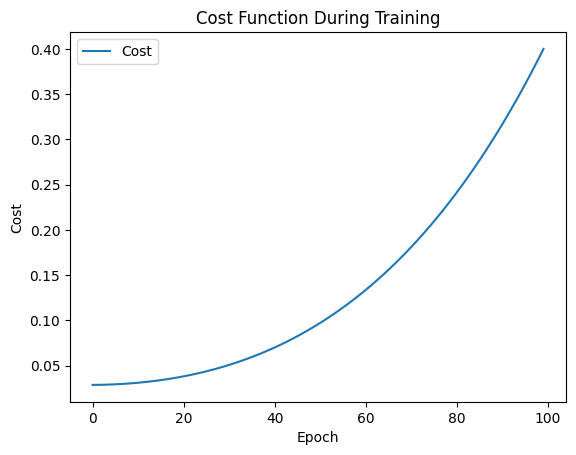

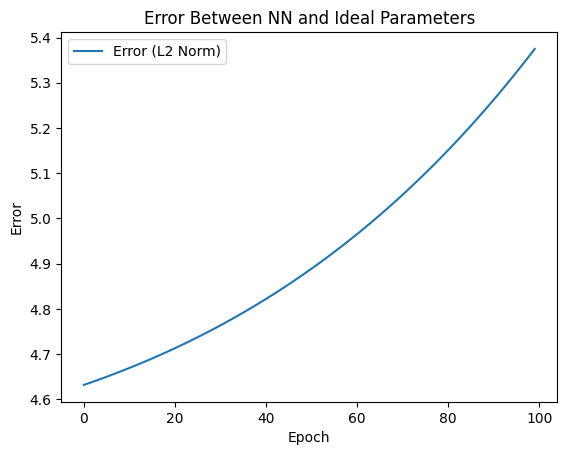

In [21]:
import numpy as np

################################################################################
# Neural Network Initialization and Training
################################################################################

def initialize_nn(MatrixM, F_vector, area_step1):
    """
    Initialize the neural network using the provided MassMatrix, F_vector, and area_step1.
    Solve the quadratic optimization problem to get initial outer parameters.
    """
    # Solve for the initial outer parameters c using M and F
    c_initial = np.linalg.solve(MatrixM, F_vector)
    return c_initial

def cost_function(c, MatrixM, F_vector, area_step1):
    """
    Compute the cost function:
        J(c) = c^T M c - 2 c^T F + area_step1
    """
    return float(np.dot(c.T, np.dot(MatrixM, c)) - 2 * np.dot(F_vector.T, c) + area_step1)

def train_nn(MatrixM, F_vector, area_step1, c_initial, ideal_parameters, learning_rate=0.01, epochs=100):
    """
    Train the neural network by minimizing the cost function using gradient descent.
    """
    c = c_initial.copy()
    errors = []  # Track errors between NN parameters and ideal parameters
    costs = []   # Track cost function values

    for epoch in range(epochs):
        # Compute gradient of the cost function: grad_J = 2 * (M c - F)
        grad_J = - np.dot(MatrixM, c)

        # Update parameters using gradient descent
        c -= learning_rate * grad_J

        # Compute the cost and error for the current parameters
        cost = cost_function(c, MatrixM, F_vector, area_step1)
        error = np.linalg.norm(c - ideal_parameters)

        costs.append(cost)
        errors.append(error)

        print(f"Epoch {epoch + 1}/{epochs} - Cost: {cost:.6f}, Error: {error:.6f}")

    return c, costs, errors

def main():
    """
    Main script for initializing and training the neural network, and analyzing errors.
    """
    # Define the triangle boundaries
    boundary_1, b1 = np.array([1, 0]), 0.0
    boundary_2, b2 = np.array([0, 1]), 0.0
    boundary_3, b3 = np.array([-1, -1]), -1.0

    # Define hyperplanes
    W = np.array([[1.0, 2.0], [2.0, -1.0], [-1.5, 1.5], [0.8, 0.6], [-2.0, -0.5]])
    B = np.array([0.5, 0.3, -0.2, 0.7, -0.8])

    # Known ideal parameters (for error analysis)
    ideal_parameters = np.array([0.7, -0.5, 0.2, 0.1, 0.3])

    # Compute the MassMatrix and F_vector
    MatrixM, F_vector, area_step1 = MassMatrix_with_F(W, B, boundary_1, boundary_2, boundary_3, b1, b2, b3)

    # Initialize the NN using the quadratic optimization solution
    c_initial = initialize_nn(MatrixM, F_vector, area_step1)

    print("\nInitial Parameters (c_initial):")
    print(c_initial)

    # Train the neural network
    c_trained, costs, errors = train_nn(MatrixM, F_vector, area_step1, c_initial, ideal_parameters)

    print("\nTrained Parameters (c_trained):")
    print(c_trained)

    # Final cost and error
    final_cost = cost_function(c_trained, MatrixM, F_vector, area_step1)
    final_error = np.linalg.norm(c_trained - ideal_parameters)

    print(f"\nFinal Cost: {final_cost:.6f}")
    print(f"Final Error (L2 Norm): {final_error:.6f}")

    # Plot cost and error
    import matplotlib.pyplot as plt

    # Cost plot
    plt.figure()
    plt.plot(range(len(costs)), costs, label="Cost")
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.title("Cost Function During Training")
    plt.legend()
    plt.show()

    # Error plot
    plt.figure()
    plt.plot(range(len(errors)), errors, label="Error (L2 Norm)")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.title("Error Between NN and Ideal Parameters")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
